# Proyecto 1
### Explorando los Algoritmos de Aprendizaje Supervisado

Estudiantes: 

Carlos Adrián Araya Ramírez---------2018319701

Michael Shakime Richards Sparks----2018170667

In [1412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import seaborn as sns


# ANÁLISIS

In [1413]:
# Load the winequality-red dataset
df = pd.read_csv("datasets/winequality-red.csv")
print(df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar   
count    1599.000000       1599.000000  1599.000000     1599.000000  \
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density   
count  1599.000000          1599.000000           1599.000000  1599.000000  \
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

<Axes: >

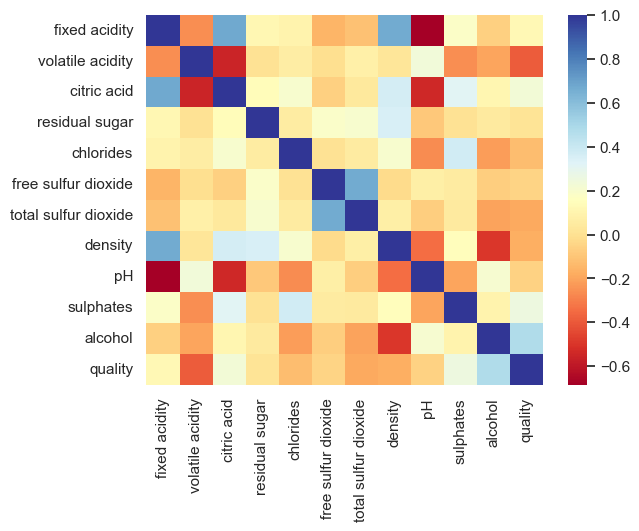

In [1414]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=False, cmap='RdYlBu')

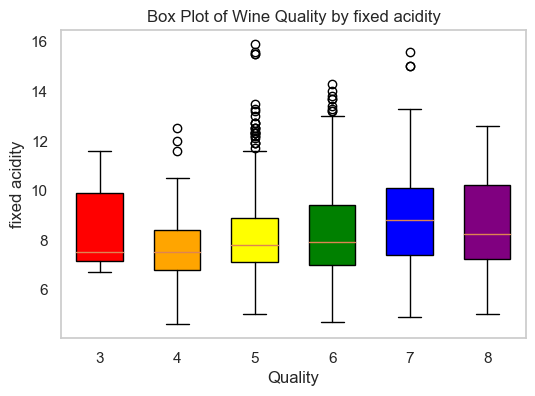

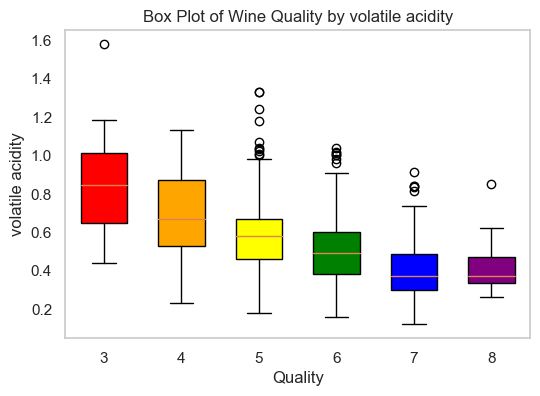

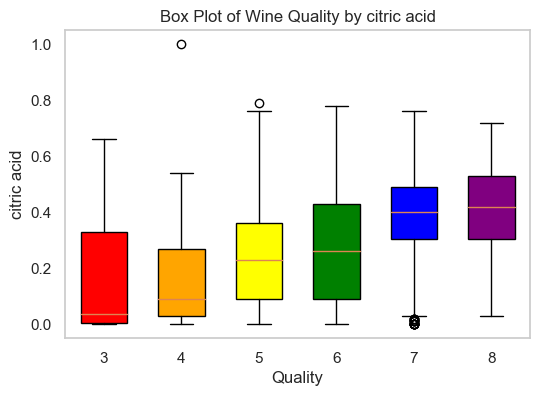

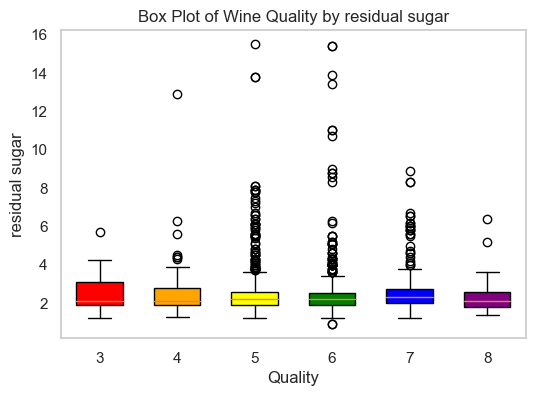

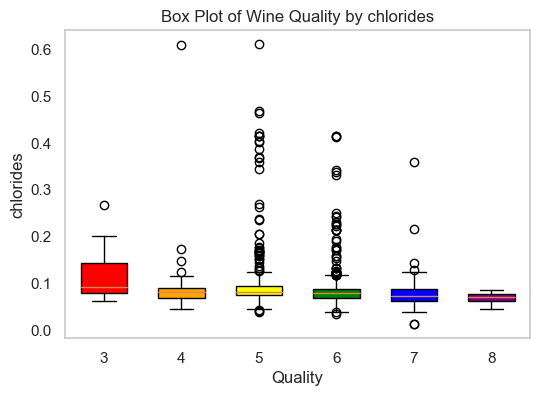

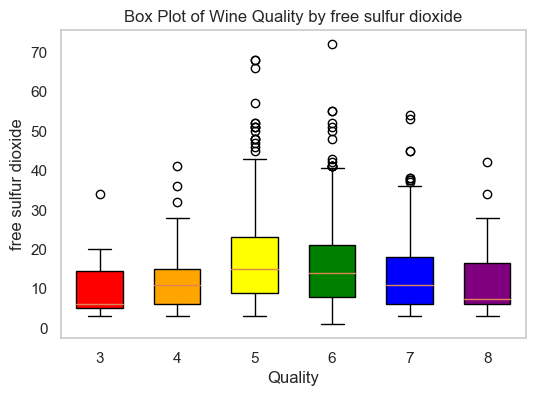

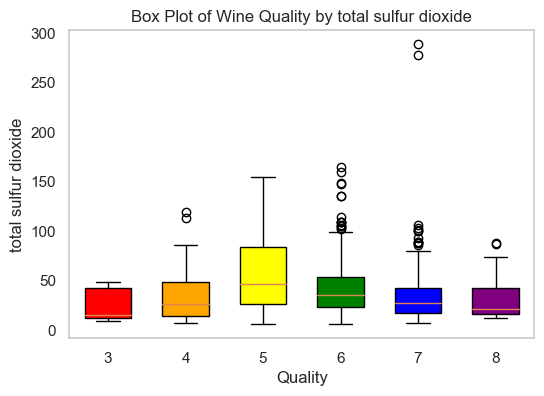

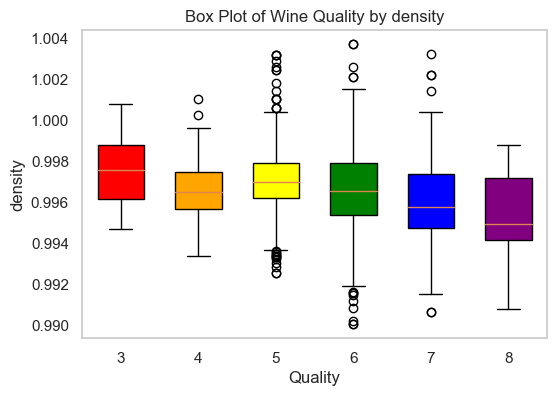

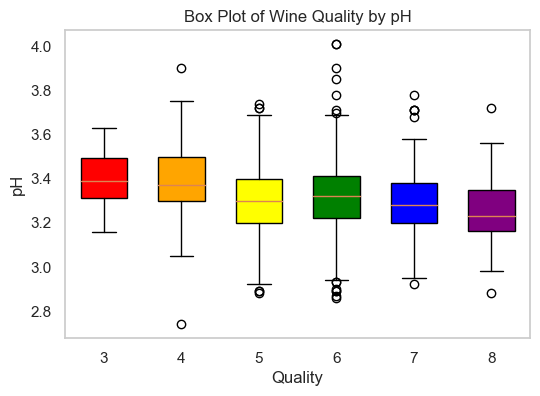

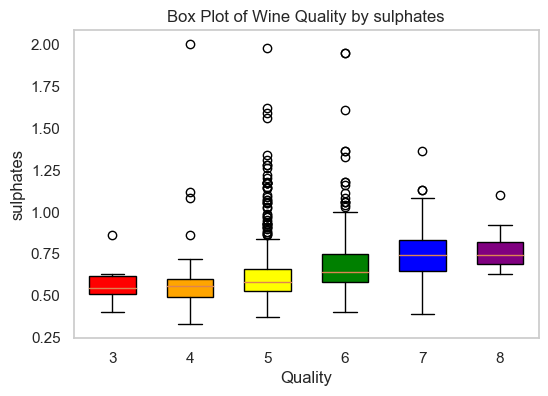

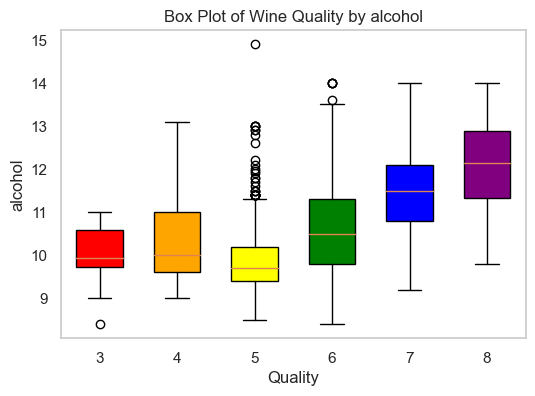

In [1415]:
# Get the list of features
features = df.columns[:-1]

# Define colors for each quality value
colors = {3: 'red', 4: 'orange', 5: 'yellow', 6: 'green', 7: 'blue', 8: 'purple'}

# Create a box plot for each feature
for feature in features:
    # Create a new figure and axis for each feature
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Loop through each quality value and plot the box
    for quality in sorted(df['quality'].unique()):
        box_color = colors[quality]  # Get the color for this quality value
        data = df[df['quality'] == quality][feature]  # Get the data for this quality value
        ax.boxplot(data, positions=[quality], widths=0.6, showfliers=True, patch_artist=True, boxprops=dict(facecolor=box_color))
    
    # Set the title and axis labels
    plt.title("Box Plot of Wine Quality by " + feature)
    plt.xlabel("Quality")
    plt.ylabel(feature)
    
    # Set the x-axis limits and ticks
    ax.set_xlim(2.5, 8.5)
    ax.set_xticks(range(3, 9))
    ax.set_xticklabels(range(3, 9))
    
    # Remove the grid lines
    ax.grid(False)
    
    # Show the plot
    plt.show()

# NORMALIZACIÓN

In [1416]:
from sklearn.preprocessing import MinMaxScaler

""" Remove outliers, this values skew the mean and standard deviation, resulting in normalization that 
is not representative of the majority of the data points. """

# Get the interquartile range for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Get the lower and upper bounds for each column
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Replace the values that are outside the interquartile range with the respective bound
df_iqr = df.clip(lower=lower, upper=upper, axis=1)

# Remove the values that are outside the interquartile range
# df_iqr = df[(df >= lower) & (df <= upper)].dropna()

""" Normalize using MinMaxScaler method. """

# Create a copy of the dataframe without the quality feature
df_to_normalize = df_iqr.iloc[:, :-1]

# Initialize the MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the df_to_normalize dataset
scaler.fit(df_to_normalize)

# Transform the df_without_quality dataset using the scaler
df_normalized = pd.DataFrame(scaler.transform(df_to_normalize), columns=df_to_normalize.columns)

# Add the quality feature of the original dataframe to the normalized dataframe
df_normalized['quality'] = df['quality']

# PREPROCESAMIENTO

In [1417]:
from collections import Counter
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split

# Divides the "quality" column into two categories using bins and labels.
bins = [2, 5.5, 8]
labels = ["MAL VINO", "BUEN VINO"]
df_normalized["quality"] = pd.cut(df_normalized["quality"], bins=bins, labels=labels)

# # show the updated dataframe
# print(df_normalized["quality"].value_counts())
# print()

# Converting the categorical labels in the "quality" column of the normalized dataset to numerical values.
lb = LabelEncoder()
df_normalized["quality"] = lb.fit_transform(df_normalized["quality"])
x = df_normalized.drop("quality", axis=1)
y = df_normalized["quality"]

# Splits the dataset into training and testing sets using train_test_split (stratifying based on the "quality" variable)
X_train,X_test,y_train,y_test=train_test_split(x, y, test_size=0.15, random_state=21, stratify=y)


# MODELOS
Evaluar de manera objetiva 3 algoritmos de aprendizaje supervisado

### REGRESIÓN LOGÍSTICA

In [1418]:
""" Find best params for the model using GridSearch """

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create an instance of the logistic regression model
log_reg = LogisticRegression(max_iter=10000)

# Create and fit GridSearchCV object to search for the best hyperparameters
grid_search = GridSearchCV(log_reg, param_grid, cv=5).fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# print the best parameters and the corresponding accuracy score
print("Best parameters: ", best_params)
print("Best score: ", best_score)


Best parameters:  {'C': 0.1}
Best score:  0.7394996744085087


In [1419]:
from sklearn.metrics import classification_report, precision_score, recall_score, roc_curve, roc_auc_score

# Create a new logistic regression model with the best parameters and make predictions
sklearn_log_reg = LogisticRegression(C=best_params['C']).fit(X_train, y_train)
y_pred_sklearn = sklearn_log_reg.predict(X_test)

# Fit my model and make predictions
# our_log_reg = OurLogisticRegression().fit(X_train, y_train)
# y_pred_our_model = our_log_reg.predict(X_test)

# Calculate sklearn accuracy, precision and recall
sklearn_accuracy = sklearn_log_reg.score(X_test, y_test)
sklearn_precision = precision_score(y_test, y_pred_sklearn)
sklearn_recall = recall_score(y_test, y_pred_sklearn)
sklearn_auc = roc_auc_score(y_test, y_pred_sklearn)

# Calculate my model metrics
our_model_accuracy = 10
our_model_precision = 10
our_model_recall = 10
our_model_auc = 10

# Create a dataframe with the metrics
metrics = {
    'Accuracy': [sklearn_accuracy, our_model_accuracy,],
    'Precision': [ sklearn_precision, our_model_precision,],
    'Recall': [sklearn_recall, our_model_recall, ],
    'AUC': [sklearn_auc, our_model_auc, ]
}
pd.DataFrame.from_dict(metrics, orient='index', columns=["Sklearn's model", 'Our model', ])

,Sklearn's model,Our model
Accuracy,0.741667,10
Precision,0.715517,10
Recall,0.741071,10
AUC,0.741629,10


              precision    recall  f1-score   support

           0       0.77      0.74      0.75       128
           1       0.72      0.74      0.73       112

    accuracy                           0.74       240
   macro avg       0.74      0.74      0.74       240
weighted avg       0.74      0.74      0.74       240



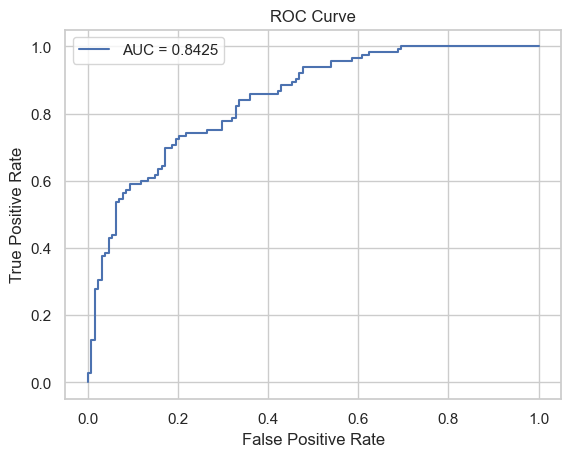

In [1420]:
# Printing stats 
print(classification_report(y_test, y_pred_sklearn))

# Calculate and plot ROC curve and AUC
y_prob = sklearn_log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### ÁRBOL


In [1421]:
""" Find best params for the model using GridSearch """

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {'max_depth': [20, 30, 40, 50],
              'min_samples_leaf': [1, 2, 4, 8],
              'min_samples_split': [2, 4, 8, 16]}

# Create a DecisionTreeClassifier instance
tree = DecisionTreeClassifier()

# Create and fit a GridSearchCV instance
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# print the best parameters and the corresponding accuracy score
print("Best parameters: ", best_params)
print("Best score: ", best_score)


Best parameters:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  0.7498073583677012


In [1422]:
from sklearn.metrics import classification_report, precision_score, recall_score, roc_curve, roc_auc_score

# Create a new decision tree model with the best parameters and make predictions
sklearn_tree = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf']).fit(X_train, y_train)
y_pred_sklearn = sklearn_tree.predict(X_test)

# Fit my model and make predictions
# our_tree = OurDecisionTree().fit(X_train, y_train)
# y_pred_our_model = our_tree.predict(X_test)

# Calculate sklearn accuracy, precision and recall
sklearn_accuracy = sklearn_tree.score(X_test, y_test)
sklearn_precision = precision_score(y_test, y_pred_sklearn)
sklearn_recall = recall_score(y_test, y_pred_sklearn)
sklearn_auc = roc_auc_score(y_test, y_pred_sklearn)

# Calculate my model metrics
our_model_accuracy = 10
our_model_precision = 10
our_model_recall = 10
our_model_auc = 10

# Create a dataframe with the metrics
metrics = {
    'Accuracy': [sklearn_accuracy, our_model_accuracy,],
    'Precision': [ sklearn_precision, our_model_precision,],
    'Recall': [sklearn_recall, our_model_recall, ],
    'AUC': [sklearn_auc, our_model_auc, ]
}
pd.DataFrame.from_dict(metrics, orient='index', columns=["Sklearn's model", 'Our model', ])


,Sklearn's model,Our model
Accuracy,0.787500,10
Precision,0.740157,10
Recall,0.839286,10
AUC,0.790737,10


              precision    recall  f1-score   support

           0       0.84      0.74      0.79       128
           1       0.74      0.84      0.79       112

    accuracy                           0.79       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.79      0.79      0.79       240



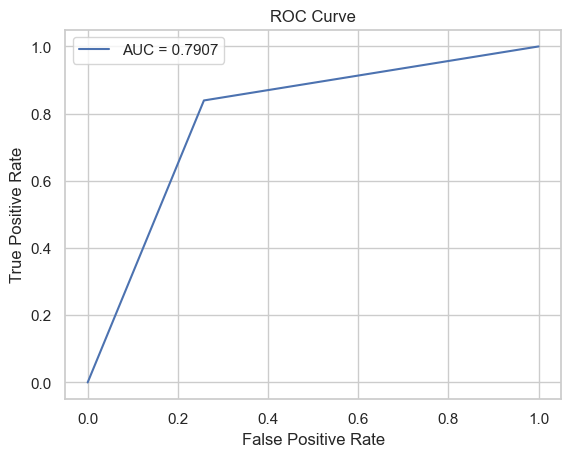

In [1423]:
# Printing stats 
print(classification_report(y_test, y_pred_sklearn))

# Calculate and plot ROC curve and AUC
y_prob = sklearn_tree.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## KNN

In [1424]:
""" Find best params for the model using GridSearch """

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance']}

# Create a KNeighborsClassifier instance
knn = KNeighborsClassifier()

# Create and fit a GridSearchCV instance
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and the corresponding accuracy score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

Best parameters:  {'n_neighbors': 9, 'weights': 'distance'}
Best score:  0.7770403733449099


In [1425]:
from sklearn.metrics import classification_report, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

# Create a new knn model with the best parameters and make predictions
sklearn_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights']).fit(X_train, y_train)
y_pred_sklearn = sklearn_knn.predict(X_test)

# Fit my model and make predictions
# our_knn = OurKNeighborsClassifier().fit(X_train, y_train)
# y_pred_our_model = our_knn.predict(X_test)

# Calculate sklearn accuracy, precision and recall
sklearn_accuracy = sklearn_knn.score(X_test, y_test)
sklearn_precision = precision_score(y_test, y_pred_sklearn)
sklearn_recall = recall_score(y_test, y_pred_sklearn)
sklearn_auc = roc_auc_score(y_test, y_pred_sklearn)

# Calculate my model metrics
our_model_accuracy = 10
our_model_precision = 10
our_model_recall = 10
our_model_auc = 10

# Create a dataframe with the metrics
metrics = {
    'Accuracy': [sklearn_accuracy, our_model_accuracy,],
    'Precision': [ sklearn_precision, our_model_precision,],
    'Recall': [sklearn_recall, our_model_recall, ],
    'AUC': [sklearn_auc, our_model_auc, ]
}
pd.DataFrame.from_dict(metrics, orient='index', columns=["Sklearn's model", 'My model', ])


,Sklearn's model,My model
Accuracy,0.841667,10
Precision,0.836364,10
Recall,0.821429,10
AUC,0.840402,10


              precision    recall  f1-score   support

           0       0.85      0.86      0.85       128
           1       0.84      0.82      0.83       112

    accuracy                           0.84       240
   macro avg       0.84      0.84      0.84       240
weighted avg       0.84      0.84      0.84       240



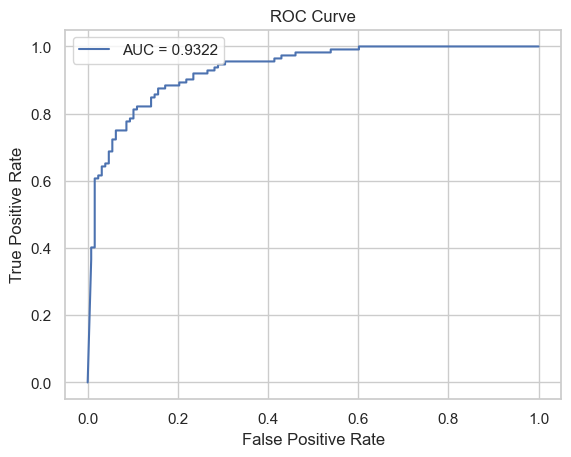

In [1426]:
# Printing stats 
print(classification_report(y_test, y_pred_sklearn))

# Calculate and plot ROC curve and AUC
y_prob = sklearn_knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()